In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURAÇÃO DE ESTILO ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# --- CARGA DE DADOS ---
try:
    # Tenta ler o Parquet (rápido e tipado)
    df = pd.read_parquet("../data/gold/opportunities.parquet")
    print("✅ Dados carregados via PARQUET!")
except FileNotFoundError:
    try:
        # Se falhar, tenta o CSV (backup)
        df = pd.read_csv("../data/gold/opportunities.csv")
        print("✅ Dados carregados via CSV!")
    except FileNotFoundError:
        print("❌ Erro Crítico: Nenhum arquivo encontrado em '../data/gold/'.")

# --- INSPEÇÃO ---
if 'df' in locals():
    print(f"\n📊 Dimensões do Dataset: {df.shape[0]} vagas encontradas.")
    display(df.head())
    print("\n🔍 Tipos de Dados:")
    df.info()

✅ Dados carregados via PARQUET!

📊 Dimensões do Dataset: 47 vagas encontradas.


,doc_id,source_name,page_num,instrumento,contexto_instrumento,tipo_vinculo,salario_valor,salario_score,distancia_chars,contexto_salario,match_type,salario_formatado
0,eea2870eeb17938823d522e22103496a,OSB,13,Violino,ertino(Tenor)-1stmovement(withoutcadence) -1st...,Não Informado,NaN,0,-1,None,NO_MATCH,Não Informado
1,348949b28bc203a6e1cf82bcfa0272cb,Filarmonica_MG,1,Violoncelo,a) vaga • SEGUNDOS VIOLINOS (Principal Assiste...,Não Informado,14002.0,5,57,S VIOLINOS (Principal Assistente): 1 (uma) vag...,PAGE_PROXIMITY,"R$ 14.002,00"
2,8140060acd1f1d7f4a191a31c5abadb9,OSB,12,Clarinete,presencial - 2ª fase - Peça de Confronto: DEBU...,Não Informado,NaN,0,-1,None,NO_MATCH,Não Informado
3,8140060acd1f1d7f4a191a31c5abadb9,OSB,5,Percussão,nista acompanhador ou utilizando playback (com...,Não Informado,NaN,0,-1,None,NO_MATCH,Não Informado
4,8140060acd1f1d7f4a191a31c5abadb9,OSB,11,Clarinete,Requinta e Clarone - 1 vaga: Pré-seleção - Víd...,Não Informado,NaN,0,-1,None,NO_MATCH,Não Informado



🔍 Tipos de Dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   doc_id                47 non-null     object 
 1   source_name           47 non-null     object 
 2   page_num              47 non-null     int64  
 3   instrumento           47 non-null     object 
 4   contexto_instrumento  47 non-null     object 
 5   tipo_vinculo          47 non-null     object 
 6   salario_valor         6 non-null      float64
 7   salario_score         47 non-null     int64  
 8   distancia_chars       47 non-null     int64  
 9   contexto_salario      6 non-null      object 
 10  match_type            47 non-null     object 
 11  salario_formatado     47 non-null     object 
dtypes: float64(1), int64(3), object(8)
memory usage: 4.5+ KB


/tmp/ipykernel_12175/20423767.py:33: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/allex/musica_market_intel/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


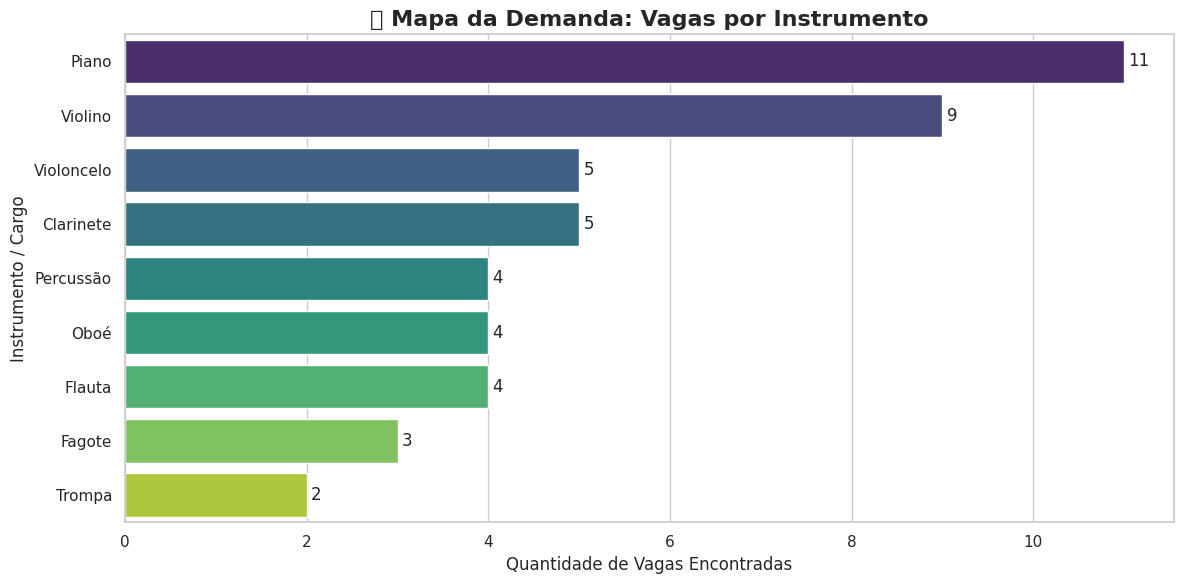

In [6]:
# --- Célula 2: Análise de Instrumentos (Blindada & Limpa) ---

# 1. Padronizar instrumento (evita NaN e remove espaços extras como "Violino ")
# Isso evita duplicatas bobas no gráfico
col = df['instrumento'].fillna("Não informado").astype(str).str.strip()

# 2. Contar a frequência (já vem ordenado do maior para o menor)
instrument_counts = col.value_counts().reset_index()
instrument_counts.columns = ['instrumento', 'total']

# 3. Criar o Gráfico de Barras
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=instrument_counts, 
    x='total', 
    y='instrumento', 
    hue='instrumento', 
    palette='viridis', 
    legend=False
)

# 4. Perfumaria
plt.title('🎹 Mapa da Demanda: Vagas por Instrumento', fontsize=16, fontweight='bold')
plt.xlabel('Quantidade de Vagas Encontradas', fontsize=12)
plt.ylabel('Instrumento / Cargo', fontsize=12)

# Adicionar números nas barras
for i in ax.containers:
    ax.bar_label(i, padding=3)

# Garante que nada fique cortado na hora de salvar
plt.tight_layout()
plt.show()

💰 Amostra de Salários Identificados: 6


/home/allex/musica_market_intel/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


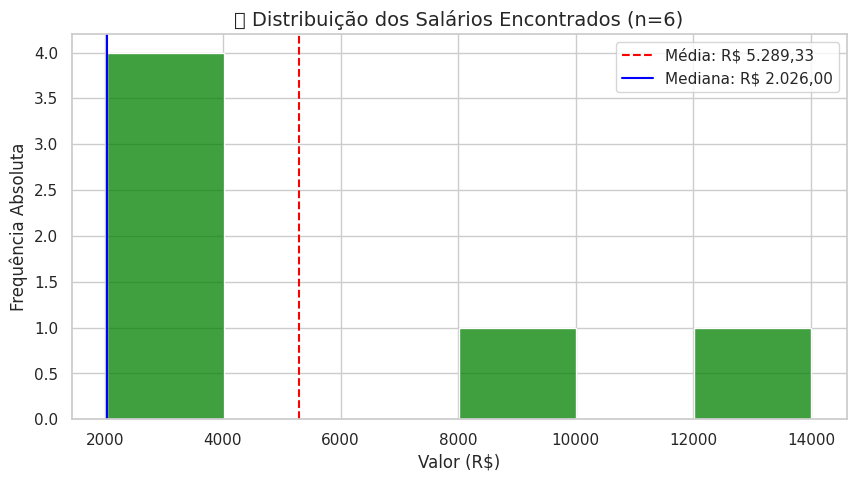

,instrumento,salario_valor,source_name
1,Violoncelo,14002.0,Filarmonica_MG
9,Percussão,2026.0,OSB
11,Clarinete,2026.0,OSB
14,Violino,2026.0,OSB
30,Fagote,9630.0,OSBA
36,Oboé,2026.0,OSB


In [7]:
# --- Célula 3: Análise de Salários (Estatística Robusta) ---

# Função auxiliar blindada para formatar dinheiro (R$ 1.234,56)
def brl(v):
    if pd.isna(v):
        return "R$ —"
    return f"R$ {v:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

# 1. Criar uma CÓPIA para não alterar os dados originais
df_analise = df.copy()

# 2. Converter nessa cópia (erros viram NaN)
df_analise['salario_valor'] = pd.to_numeric(df_analise['salario_valor'], errors='coerce')

# 3. Filtrar apenas salários válidos (> 0)
df_salarios = df_analise[df_analise['salario_valor'] > 0]
n_amostra = len(df_salarios)

print(f"💰 Amostra de Salários Identificados: {n_amostra}")

if not df_salarios.empty:
    # 4. Criar Histograma (Sem KDE para não distorcer dados pequenos)
    plt.figure(figsize=(10, 5))
    
    # Bins dinâmicos: se tivermos poucos dados, usamos menos barras
    sns.histplot(
        data=df_salarios, 
        x='salario_valor', 
        kde=False, 
        bins=min(8, n_amostra), 
        color='green'
    )

    # 5. Linhas de Referência
    media = df_salarios['salario_valor'].mean()
    mediana = df_salarios['salario_valor'].median()

    plt.axvline(media, color='red', linestyle='--', label=f"Média: {brl(media)}")
    plt.axvline(mediana, color='blue', linestyle='-', label=f"Mediana: {brl(mediana)}")

    plt.title(f'💸 Distribuição dos Salários Encontrados (n={n_amostra})', fontsize=14)
    plt.xlabel('Valor (R$)', fontsize=12)
    plt.ylabel('Frequência Absoluta', fontsize=12)
    plt.legend()
    plt.show()
    
    # Mostrar tabela detalhada
    display(df_salarios[['instrumento', 'salario_valor', 'source_name']])
else:
    print("⚠️ Nenhum salário numérico encontrado para plotar.")

In [8]:
# --- Célula 4: Auditoria Técnica para Melhoria do Regex ---

# Segurança: garante que df_analise existe mesmo se rodar células fora de ordem
if 'df_analise' not in locals():
    df_analise = df.copy()
    df_analise['salario_valor'] = pd.to_numeric(df_analise['salario_valor'], errors='coerce')

# Filtrar onde o salário é Nulo ou Zero
auditoria = df_analise[(df_analise['salario_valor'].isna()) | (df_analise['salario_valor'] == 0)]

print(f"🔎 Total de casos sem salário identificado: {len(auditoria)}")
print("Amostra ALEATÓRIA de casos para auditoria técnica:")

# Pega até 5 exemplos aleatórios (Random State 42 garante que sejam sempre os mesmos)
amostra = auditoria.sample(n=min(5, len(auditoria)), random_state=42)

for index, row in amostra.iterrows():
    print(f"\n--- Vaga: {row['instrumento']} ({row['source_name']}) ---")
    
    # Dados Técnicos para Debug
    print(f"🔧 Debug: Página={row.get('page_num')} | Tipo Match={row.get('match_type')} | Formatado Original={row.get('salario_formatado')}")

    # Investigação de Contexto
    ctx_sal = row.get('contexto_salario')
    ctx_inst = row.get('contexto_instrumento')
    
    if pd.notna(ctx_sal) and str(ctx_sal).strip():
        print(f"Texto ao redor (Salário): '{ctx_sal}'")
    elif pd.notna(ctx_inst) and str(ctx_inst).strip():
        print(f"Texto ao redor (Instrumento): '{ctx_inst}'")
        print("💡 Dica: O valor pode estar escrito por extenso ou longe do instrumento.")
    else:
        print("Texto ao redor: [Nenhum contexto capturado]")

🔎 Total de casos sem salário identificado: 41
Amostra ALEATÓRIA de casos para auditoria técnica:

--- Vaga: Fagote (OSBA) ---
🔧 Debug: Página=1 | Tipo Match=NO_MATCH | Formatado Original=Não Informado
Texto ao redor (Instrumento): 'AGA Flauta Chefe de Naipe 01 Trompa Chefe de Naipe 01 Tímpano Chefe de Naipe 01 Fagote Fila* 01 * A vaga corresponde a Fila – Utilitário, e exigirá do músico contrata'
💡 Dica: O valor pode estar escrito por extenso ou longe do instrumento.

--- Vaga: Clarinete (OSB) ---
🔧 Debug: Página=14 | Tipo Match=NO_MATCH | Formatado Original=Não Informado
Texto ao redor (Instrumento): 'úmero 26 até 6 compassos antes de 27. STRAVINSKY, I. – Sagração da Primavera: - Clarone 2: Do número 1 até 4 compassos antes de 2; - Clarone 2: Do número 6 até 8 compa'
💡 Dica: O valor pode estar escrito por extenso ou longe do instrumento.

--- Vaga: Piano (OSB) ---
🔧 Debug: Página=7 | Tipo Match=NO_MATCH | Formatado Original=Não Informado
Texto ao redor (Instrumento): 'de selecionados 